# Batch effects

Biological processes are not the only source of variability in datasets. Technical biases are also a source of variability in a sample. One of the challenges of data integration of large-scale transcriptomic datasets generated using different technologies is batch-specific systematic variations that present a challenge to batch-effect removal.







ComBat is one of the most widely used tool for correcting
those technical biases, called batch effects, in microarray expression data. 

# 1. Microarray

Microarray experiments are very sensitive to experimental conditions: Equipment, agents,technicians,etc.
Data generated from	different “batches” (lab,time,etc.)	can	be	quite different,	but	data	from	the	same batch	tend	to	be	more	similar. So	batch	effects	are	structured	noise/bias	common to	all	replicates in	the	same	batch,	but	markedly different	from	batch	to	batch.	
ComBat 

pyComBat (Behdenna et al, 2020) is a new Python implementation of ComBat (Johnson et al, 2007), a software which is one of the most widely used tool for correcting those technical biases called batch effects.

# 1.1 Methods	to	remove	batch	effects

-Based	on	linear	model:	batches	cause location/scale changes.	
-Based	on	dimension	reduction	technique: SVD,	PCA,	factor	analysis,	etc.

# 2. RNAseq

Batch effects in RNAseq are also due to technical differences between your samples, such as the type of sequencing machine or even the technician that ran the sample. Removing this variability means changing the data for individual samples. 

The package **BatchQC** shows us if we have a batch effect. This R module provides interactive diagnostics, visualizations, and statistical analyses to explore the extent to which batch variation impacts our data. 


**ComBat-seq** is a batch effect adjustment tool for bulk RNA-seq count data. **removeBatchEffect()** in Limma and **batch** in Deseq2 is essentially treated as a covariate in the regression model.

# 3. scRNAseq

Effective batch-effect removal is also essential in scRNAseq. Batch effects can be highly nonlinear, making it difficult to correctly align different datasets while preserving key biological variations. The tools already developed for microarray data batch correction such as ComBat and limma could be employed on single-cell RNA-seq (scRNA-seq) data to address these challenges. SCANPY is one of the scalable toolkit used for analyzing single-cell gene expression data. It's a Python-based implementation with advanced machine-learning packages, such as TENSORFLOW


## 3.1 Example

The following data has been used in the scGen paper [Lotfollahi19](https://www.nature.com/articles/s41592-019-0494-8), has been used [here](https://nbviewer.jupyter.org/github/M0hammadL/scGen_notebooks/blob/master/notebooks/scgen_batch_removal.ipynb).

It contains data for human pancreas from 4 different studies (Segerstolpe16, Baron16, Wang16, Muraro16), which have been used in the seminal papers on single-cell dataset integration (Butler18, Haghverdi18) and many times ever since.



In [5]:
import scgen
import scanpy as sc

## Reading the train data

In [14]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')


/home/hedia/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/hedia/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [15]:
adata_all.shape

(14693, 2448)

In [16]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

To simplify visualization, it's better to remove the 5 minority classes.

In [17]:
minority_classes = counts.index[-5:].tolist()        # get the minority classes
adata_all = adata_all[                               # actually subset
    ~adata_all.obs.celltype.isin(minority_classes)]
adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance
    counts.index[:-5].tolist(), inplace=True)

Seeing the batch effect

In [18]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

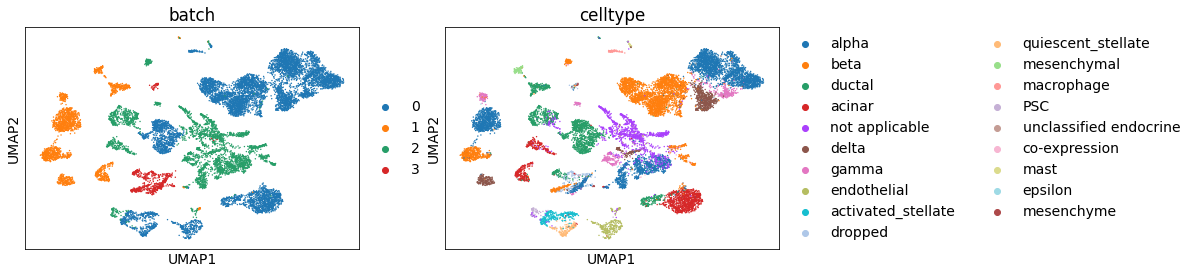

In [19]:
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)

There's a batch effect.

It can be well-resolved using BBKNN [Polanski19].

In [23]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

CPU times: user 2.31 s, sys: 79.4 ms, total: 2.39 s
Wall time: 2.23 s


In [24]:
sc.tl.umap(adata_all)

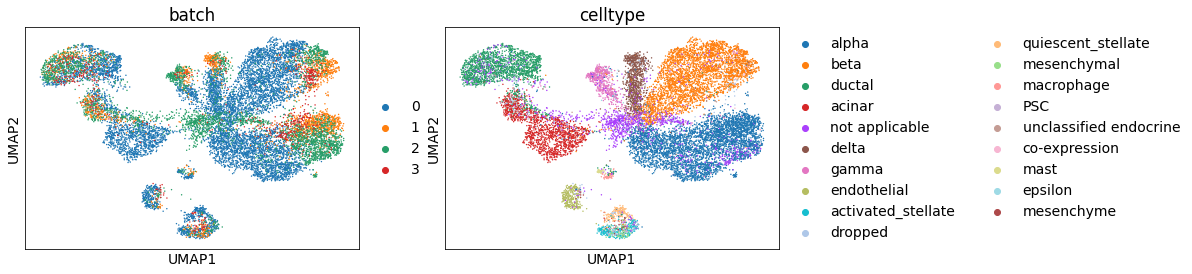

In [25]:
sc.pl.umap(adata_all, color=['batch', 'celltype'])